# MCMC Infering

### Problem

Let Y and X be a response and a predictor for the model, respectively. A linear model states that the conditional distribution of the response given such predictor is normal. That is:
$$ Y|X \sim \mathcal{N}(aX+b, \sigma^2)$$ 

Text(0, 0.5, 'y')

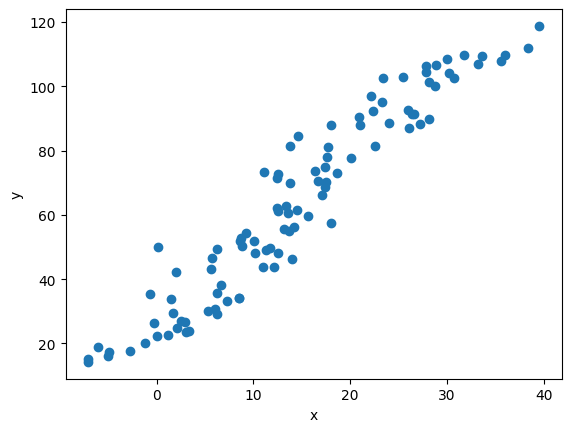

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sc

# sample x
np.random.seed(2022)
x = np.random.rand(100)*30

# set parameters
a = 3
b = 20
sigma = 5


# obtain response and add noise
y = a*x+b
noise = np.random.randn(100)*sigma

# create a matrix containing the predictor in the first column
# and the response in the second
data = np.vstack((x,y)).T + noise.reshape(-1,1)

# plot data 
plt.scatter(data[:,0], data[:,1])
plt.xlabel("x")
plt.ylabel("y")

## The Algorithm

Let $\theta=[a,b,\sigma]$ be the vector of parameters at the previous step of the algorithm and θ’ be a proposal for a new set of parameters, MH compares the Bayes Factor (the product of likelihood and prior) between two competing hypotheses for the parameters (θ’ and θ) and scales this factor by the reciprocal of the conditional proposal distribution. This factor is then compared with the value of a uniformly distributed random variable. This adds stochasticity to the model and makes it possible for unlikely parameter vectors to be explored and for likely ones to be discarded (rarely).

### The Proposal Distribution

First, we define a proposal distribution g(θ’|θ): this is a distribution for fixed parameters at the previous time step. In our example, a and b can be both positive and negative, therefore a natural choice would be sampling them from a multivariate normal distribution centered at the previous iteration step. As for σ, we can for example sample it from a Gamma distribution. It is really up to the user defining all these distributions. A better approach (which we will not cover here) would involve sampling σ from an inverse Gamma distribution instead.
<img src='https://miro.medium.com/v2/resize:fit:1140/format:webp/1*E7lfeQYcLcVUIdXHvpSS6A.png' />

<img src='https://miro.medium.com/v2/resize:fit:652/format:webp/1*Gx3OaDKEE3EshtCdQYvCtg.png'>

In [4]:
def proposal(prec_theta, search_width = 0.5):
    # this function generates the proposal for the new theta
    # we assume that the distribution of the random variables 
    # is normal for the first two and gamma for the third.
    # conditional on the previous value of the accepted parameters (prec_theta)
    out_theta = np.zeros(3)
    out_theta[:2] = sc.multivariate_normal(mean=prec_theta[:2],cov=np.eye(2)*search_width**2).rvs(1)
    #the last component is the noise
    out_theta[2] = sc.gamma(a=prec_theta[2]*search_width*500, scale=1/(500*search_width)).rvs()
    return out_theta

### The Likelihood Function

In [5]:

def lhd(x,theta):
    # x is the data matrix, first column for input and second column for output.
    # theta is a vector containing the parameters for the evaluation
    # remember theta[0] is a, theta[1] is b and theta[2] is sigma
    xs = x[:,0]
    ys = x[:,1]
    lhd_out = sc.norm.logpdf(ys, loc=theta[0]*xs+theta[1], scale=theta[2])
    # then we sum lhd_out (be careful here, we are summing instead of multiplying
    # because we are dealing with the log-likelihood, instead of the raw likelihood).
    lhd_out = np.sum(lhd_out)
    return lhd_out

### The Prior

In [6]:
def prior(theta):
    # evaluate the prior for the parameters on a multivariate gaussian. 
    prior_out = sc.multivariate_normal.logpdf(theta[:2],mean=np.array([0,0]), cov=np.eye(2)*100)
    # this needs to be summed to the prior for the sigma, since I assumed independence.
    prior_out += sc.gamma.logpdf(theta[2], a=1, scale=1)
    return prior_out

### The Proposal Ratio

The proposal ratio is the likelihood of observing the old parameter vector given the new one divided by the probability of observing the new parameter vector given the old one.

In [7]:
def proposal_ratio(theta_old, theta_new, search_width=10):
    # this is the proposal distribution ratio
    # first, we calculate of the pdf of the proposal distribution at the old value of theta with respect to the new 
    # value of theta. And then we do the exact opposite.
    prop_ratio_out = sc.multivariate_normal.logpdf(theta_old[:2],mean=theta_new[:2], cov=np.eye(2)*search_width**2)
    prop_ratio_out += sc.gamma.logpdf(theta_old[2], a=theta_new[2]*search_width*500, scale=1/(500*search_width))
    prop_ratio_out -= sc.multivariate_normal.logpdf(theta_new[:2],mean=theta_old[:2], cov=np.eye(2)*search_width**2)
    prop_ratio_out -= sc.gamma.logpdf(theta_new[2], a=theta_old[2]*search_width*500, scale=1/(500*search_width))
    return prop_ratio_out

### In All

```
# 1) Instantiate initial values for the parameter vector

... N TIMES or UNTIL CONVERGENCE
# 2) Draw a new parameter vector from the proposal
# 3) Calculate likelihood, prior pdf value and the reciprocal of the proposal likelihood ratio
# 4) Multiply all the quantities in 3 (or sum if in log) and compare this ratio (in linear scale)
     against a number drawn from a uniform distribution. 
# 5) If the ratio is larger, the new parameter vector is accepted.
     Otherwise, the new parameter vector is rejected.
# 6) Move to 2)
```

In [8]:
np.random.seed(100)
width = 0.2

thetas = np.random.rand(3).reshape(1,-1)
accepted = 0
rejected = 0

N = 20000

for i in range(N):

    # 1) provide a proposal for theta
    theta_new = proposal(thetas[-1,:], search_width=width)
    
    # 2) calculate the likelihood of this proposal and the likelihood
    # for the old value of theta
    log_lik_theta_new = lhd(data,theta_new)
    log_lik_theta = lhd(data,thetas[-1,:])
    
    # 3) evaluate the prior log-pdf at the current and at the old value of theta
    theta_new_prior = prior(theta_new)
    theta_prior = prior(thetas[-1,:])
    
    # 4) finally, we need the proposal distribution ratio
    prop_ratio = proposal_ratio(thetas[-1], theta_new, search_width=width)
    
    # 5) assemble likelihood, priors and proposal distributions
    likelihood_prior_proposal_ratio = log_lik_theta_new - log_lik_theta + \
                             theta_new_prior - theta_prior + prop_ratio
    
    # 6) throw a - possibly infinitely weigthed - coin. The move for Metropolis-Hastings is
    # not deterministic. Here, we exponentiate the likelihood_prior_proposal ratio in order
    # to obtain the probability in linear scale
    if np.exp(likelihood_prior_proposal_ratio) > sc.uniform().rvs():
        thetas = np.vstack((thetas,theta_new))
        accepted += 1
    else:
        rejected += 1

/var/folders/zk/83r7bdpd2g11psvjbywlbxsr0000gn/T/ipykernel_54367/3165780626.py:34: RuntimeWarning: overflow encountered in exp
  if np.exp(likelihood_prior_proposal_ratio) > sc.uniform().rvs():


## OLS

In [ ]:
import statsmodels.api as sm
import pandas as pd

df = pd.DataFrame(data)
df.columns = ["a","y"]
df["b"] = 1
lm = sm.OLS(df["y"], df[["a","b"]]).fit()
lm.summary()

## Resources

* https://theoreticalecology.wordpress.com/2010/09/17/metropolis-hastings-mcmc-in-r/
* https://medium.com/@tinonucera/bayesian-linear-regression-from-scratch-a-metropolis-hastings-implementation-63526857f191

* RVS: https://miro.medium.com/v2/resize:fit:652/format:webp/1*Gx3OaDKEE3EshtCdQYvCtg.png